In [1]:
# === Cell 1: Setup + Load + Feature Engineering (relative to enrollment) ===
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import joblib
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, roc_auc_score,
    precision_recall_curve, roc_curve, average_precision_score
)
from sklearn.model_selection import GroupKFold
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.preprocessing import PowerTransformer

import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
DATA_DIR = Path("datasets")
MODULE = "BBB"
PRESENTATIONS = ["2013B", "2013J"]

# Bạn có thể chọn 1 trong 2:
# 1) cutoff rời rạc như bạn đang làm
CUTOFFS = [7, 14, 30, 60, 90, 120, 150, 180]
# 2) cutoff dày hơn để model quen cutoff lẻ (khuyên dùng):
# CUTOFFS = list(range(1, 181))

WINDOW_DAYS = 14
HALF_WINDOW = 7
VAR_THRESH = 0.0
MODEL_PATH = "dropout_model_relative.pkl"

RANDOM_STATE = 42

logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s - %(message)s")


# -------------------------
# IO
# -------------------------
def load_raw(data_dir: Path) -> Dict[str, pd.DataFrame]:
    raw = {
        "student_info": pd.read_csv(data_dir / "studentInfo.csv"),
        "student_reg": pd.read_csv(data_dir / "studentRegistration.csv"),
        "student_vle": pd.read_csv(data_dir / "studentVle.csv"),
        "student_ass": pd.read_csv(data_dir / "studentAssessment.csv"),
        "assessments": pd.read_csv(data_dir / "assessments.csv"),
    }
    return raw


def prepare_students(
    raw: Dict[str, pd.DataFrame], module: str, presentations: List[str]
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Filter registration of module/presentation
    reg_mod = raw["student_reg"].loc[
        (raw["student_reg"]["code_module"] == module)
        & (raw["student_reg"]["code_presentation"].isin(presentations)),
        ["id_student", "date_registration"],
    ].drop_duplicates()

    # Student info (label)
    students = raw["student_info"].loc[
        (raw["student_info"]["code_module"] == module)
        & (raw["student_info"]["code_presentation"].isin(presentations))
        & (raw["student_info"]["id_student"].isin(reg_mod["id_student"])),
        ["id_student", "final_result"],
    ].copy()

    students["dropout"] = (students["final_result"] == "Withdrawn").astype(int)
    students = students[["id_student", "dropout"]].drop_duplicates()

    # VLE merge registration to build relative day
    vle_mod = raw["student_vle"].loc[
        (raw["student_vle"]["code_module"] == module)
        & (raw["student_vle"]["code_presentation"].isin(presentations)),
        ["id_student", "date", "sum_click"],
    ].merge(reg_mod, on="id_student", how="inner")

    # Ensure numeric + relative
    vle_mod["date"] = pd.to_numeric(vle_mod["date"], errors="coerce")
    vle_mod["date_registration"] = pd.to_numeric(vle_mod["date_registration"], errors="coerce")
    vle_mod["sum_click"] = pd.to_numeric(vle_mod["sum_click"], errors="coerce").fillna(0)

    vle_mod["days_since_reg"] = vle_mod["date"] - vle_mod["date_registration"]
    # Drop weird negative days (activity before registration)
    vle_mod = vle_mod.loc[vle_mod["days_since_reg"].notna() & (vle_mod["days_since_reg"] >= 0)].copy()
    vle_mod["days_since_reg"] = vle_mod["days_since_reg"].astype(int)

    # Assessments merge reg; compute relative day using date_submitted
    ass_mod = raw["student_ass"].loc[
        :, ["id_student", "id_assessment", "date_submitted", "score"]
    ].merge(reg_mod, on="id_student", how="inner")

    ass_mod["date_submitted"] = pd.to_numeric(ass_mod["date_submitted"], errors="coerce")
    ass_mod["date_registration"] = pd.to_numeric(ass_mod["date_registration"], errors="coerce")
    ass_mod["score"] = pd.to_numeric(ass_mod["score"], errors="coerce")

    ass_mod["days_since_reg"] = ass_mod["date_submitted"] - ass_mod["date_registration"]
    # Keep only valid submissions with non-negative relative day
    ass_mod = ass_mod.loc[
        ass_mod["date_submitted"].notna()
        & ass_mod["days_since_reg"].notna()
        & (ass_mod["days_since_reg"] >= 0)
    ].copy()
    ass_mod["days_since_reg"] = ass_mod["days_since_reg"].astype(int)

    logging.info("So hoc vien hop le: %d", students["id_student"].nunique())
    return students, vle_mod, ass_mod


# -------------------------
# Feature helpers
# -------------------------
def compute_inactivity_streak(days_list: List[int], start_day: int, end_day: int) -> int:
    """How many consecutive inactive days at the tail of [start_day..end_day]."""
    if not days_list:
        return end_day - start_day + 1
    active = set(days_list)
    streak = 0
    d = end_day
    while d >= start_day and d not in active:
        streak += 1
        d -= 1
    return streak


def _safe_div(a: pd.Series, b: pd.Series, fill: float = 0.0) -> pd.Series:
    out = a / b.replace(0, np.nan)
    return out.fillna(fill)


def build_features_relative(
    students: pd.DataFrame,
    vle_mod: pd.DataFrame,
    ass_mod: pd.DataFrame,
    assessments: pd.DataFrame,
    cutoffs: List[int],
    window_days: int = WINDOW_DAYS,
    half_window: int = HALF_WINDOW,
    use_assessment_features: bool = False,  # bạn bật True nếu muốn xài assessment
) -> Tuple[pd.DataFrame, List[str]]:
    # If you only want assessments belonging to module/presentation scope, keep ids list
    target_assessment_ids = assessments["id_assessment"].dropna().unique()

    augmented = []

    for cutoff in cutoffs:
        w_start = max(0, cutoff - (window_days - 1))
        w_end = cutoff

        # -------------------------
        # VLE (cumulative <= cutoff)
        # -------------------------
        vle_cum = vle_mod.loc[vle_mod["days_since_reg"] <= cutoff].copy()
        vle_win = vle_cum.loc[vle_cum["days_since_reg"] >= w_start].copy()

        cum_agg = (
            vle_cum.groupby("id_student", as_index=False)
            .agg(
                total_clicks=("sum_click", "sum"),
                active_days_total=("days_since_reg", "nunique"),
                last_active=("days_since_reg", "max"),
            )
        )

        cum_agg["days_elapsed_since_reg"] = cutoff
        cum_agg["clicks_per_day_total"] = cum_agg["total_clicks"] / max(cutoff, 1)
        cum_agg["active_ratio_total"] = cum_agg["active_days_total"] / max(cutoff, 1)
        cum_agg["days_since_last_active"] = cutoff - cum_agg["last_active"]
        cum_agg["avg_clicks_per_active_day_total"] = _safe_div(
            cum_agg["total_clicks"], cum_agg["active_days_total"], fill=0.0
        )

        win_agg = (
            vle_win.groupby("id_student", as_index=False)
            .agg(
                clicks_last_14_days=("sum_click", "sum"),
                active_days_14=("days_since_reg", "nunique"),
            )
        )
        win_agg["clicks_per_day_14"] = win_agg["clicks_last_14_days"] / window_days
        win_agg["active_ratio_14"] = win_agg["active_days_14"] / window_days

        # Split window into two halves (0-7, 8-14 relative inside the window)
        first_end = min(w_end, w_start + (half_window - 1))
        second_start = min(w_end, first_end + 1)

        clicks_0_7 = (
            vle_win.loc[(vle_win["days_since_reg"] >= w_start) & (vle_win["days_since_reg"] <= first_end)]
            .groupby("id_student")["sum_click"]
            .sum()
            .rename("clicks_0_7")
            .reset_index()
        )

        clicks_8_14 = (
            vle_win.loc[(vle_win["days_since_reg"] >= second_start) & (vle_win["days_since_reg"] <= w_end)]
            .groupby("id_student")["sum_click"]
            .sum()
            .rename("clicks_8_14")
            .reset_index()
        )

        clicks_last_7 = (
            vle_cum.loc[vle_cum["days_since_reg"] > (cutoff - 7)]
            .groupby("id_student")["sum_click"]
            .sum()
            .rename("clicks_last_7_days")
            .reset_index()
        )

        # Inactivity streak in last 14 days
        days_list = (
            vle_win.groupby("id_student")["days_since_reg"]
            .apply(lambda x: sorted(x.unique().tolist()))
            .rename("active_days_list")
            .reset_index()
        )
        days_list["inactivity_streak_14"] = days_list["active_days_list"].apply(
            lambda lst: compute_inactivity_streak(lst, w_start, w_end)
        )
        streak = days_list[["id_student", "inactivity_streak_14"]]

        # -------------------------
        # Assessments (optional)
        # -------------------------
        ass_agg = None
        ass_agg_14 = None
        if use_assessment_features:
            ass_cum = ass_mod.loc[
                (ass_mod["id_assessment"].isin(target_assessment_ids))
                & (ass_mod["days_since_reg"] <= cutoff)
            ].copy()

            ass_agg = (
                ass_cum.groupby("id_student", as_index=False)
                .agg(
                    num_assessments=("id_assessment", "nunique"),
                    avg_score=("score", "mean"),
                    pass_count=("score", lambda x: (x >= 40).sum()),
                    last_score=("score", "last"),
                )
            )

            ass_win = ass_cum.loc[ass_cum["days_since_reg"] >= w_start]
            ass_agg_14 = (
                ass_win.groupby("id_student", as_index=False)
                .agg(
                    num_assessments_14=("id_assessment", "nunique"),
                    avg_score_14=("score", "mean"),
                )
            )

        # -------------------------
        # Merge all
        # -------------------------
        merged = students.merge(cum_agg, on="id_student", how="left")
        merged = merged.merge(win_agg, on="id_student", how="left")
        merged = merged.merge(clicks_0_7, on="id_student", how="left")
        merged = merged.merge(clicks_8_14, on="id_student", how="left")
        merged = merged.merge(clicks_last_7, on="id_student", how="left")
        merged = merged.merge(streak, on="id_student", how="left")

        if use_assessment_features and ass_agg is not None:
            merged = merged.merge(ass_agg, on="id_student", how="left")
            merged = merged.merge(ass_agg_14, on="id_student", how="left")

        # Fill missing with 0
        fill0_cols = [
            "total_clicks",
            "active_days_total",
            "last_active",
            "clicks_last_14_days",
            "active_days_14",
            "clicks_0_7",
            "clicks_8_14",
            "clicks_last_7_days",
            "inactivity_streak_14",
            "clicks_per_day_total",
            "active_ratio_total",
            "avg_clicks_per_active_day_total",
            "days_since_last_active",
            "clicks_per_day_14",
            "active_ratio_14",
        ]
        if use_assessment_features:
            fill0_cols += [
                "num_assessments",
                "avg_score",
                "pass_count",
                "last_score",
                "num_assessments_14",
                "avg_score_14",
            ]
        for c in fill0_cols:
            merged[c] = merged[c].fillna(0)

        # Derived
        merged["trend_click_14"] = merged["clicks_8_14"] - merged["clicks_0_7"]
        merged["ratio_click_14"] = (merged["clicks_8_14"] + 1) / (merged["clicks_0_7"] + 1)
        merged["days_elapsed_since_reg"] = cutoff

        augmented.append(merged)

    final_df = pd.concat(augmented, ignore_index=True)

    feature_cols = [
        "days_elapsed_since_reg",
        "clicks_per_day_total",
        "active_ratio_total",
        "avg_clicks_per_active_day_total",
        "days_since_last_active",
        "clicks_last_14_days",
        "active_days_14",
        "clicks_per_day_14",
        "active_ratio_14",
        "clicks_last_7_days",
        "clicks_0_7",
        "clicks_8_14",
        "trend_click_14",
        "ratio_click_14",
        "inactivity_streak_14",
    ]
    if use_assessment_features:
        feature_cols += [
            "num_assessments",
            "avg_score",
            "pass_count",
            "last_score",
            "num_assessments_14",
            "avg_score_14",
        ]

    return final_df, feature_cols


# -------------------------
# Pipelines
# -------------------------
def make_eval_pipe(model):
    return ImbPipeline(
        steps=[
            ("variance_threshold", VarianceThreshold(VAR_THRESH)),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("power_transformer", PowerTransformer()),
            ("classifier", model),
        ]
    )

def make_prod_pipe(model):
    return SkPipeline(
        steps=[
            ("variance_threshold", VarianceThreshold(VAR_THRESH)),
            ("power_transformer", PowerTransformer()),
            ("classifier", model),
        ]
    )


# -------------------------
# Models
# -------------------------
MODELS = {
    "GradientBoostingClassifier": GradientBoostingClassifier(
        learning_rate=0.03,
        loss="exponential",
        max_depth=3,
        min_samples_leaf=40,
        min_samples_split=20,
        n_estimators=120,           # 10 hơi ít, tăng lên ổn định hơn
        n_iter_no_change=10,
        random_state=RANDOM_STATE
    ),
    "RandomForestClassifier": RandomForestClassifier(
        criterion="gini",
        max_depth=12,
        min_samples_leaf=5,
        min_samples_split=10,
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced",    # ổn cho bài toán cảnh báo (ưu tiên recall)
    ),
    "MLPClassifier": MLPClassifier(
        alpha=0.0005,
        early_stopping=True,
        hidden_layer_sizes=(128, 64),
        learning_rate_init=0.01,
        max_iter=800,
        random_state=RANDOM_STATE
    ),
    "LogisticRegression": LogisticRegression(
        penalty="l1",
        solver="saga",
        max_iter=3000,
        random_state=RANDOM_STATE,
    ),
}


[2025-12-27 11:10:38,502] INFO - So hoc vien hop le: 3960
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use

Hiệu năng trung bình (sort theo F1):


,model,mean_accuracy,mean_f1,mean_recall,mean_specificity,mean_auc
0,GradientBoostingClassifier,0.591611,0.532627,0.820597,0.500728,0.729324
1,RandomForestClassifier,0.596471,0.530758,0.804671,0.513886,0.726795
2,MLPClassifier,0.580418,0.529727,0.833189,0.480116,0.719502
3,LogisticRegression,0.577127,0.527137,0.831135,0.476282,0.711160



Best model theo mean F1: GradientBoostingClassifier


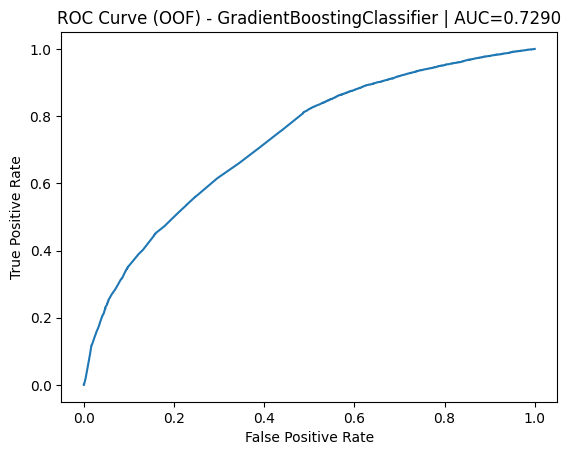

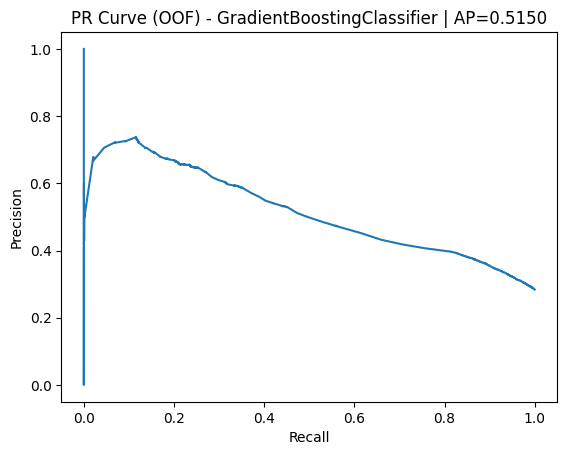

Đã lưu model vào dropout_model_relative.pkl với model GradientBoostingClassifier

Top 10 rủi ro cao nhất (ở cutoff lớn nhất):


,id_student,days_elapsed_since_reg,dropout_proba,days_elapsed_since_reg,clicks_per_day_total,active_ratio_total,avg_clicks_per_active_day_total,days_since_last_active
3986,2693772,7,0.30363,7,0.0,0.0,0.0,0.0
0,23629,7,0.30363,7,0.0,0.0,0.0,0.0
1,25107,7,0.30363,7,0.0,0.0,0.0,0.0
3970,2631545,7,0.30363,7,0.0,0.0,0.0,0.0
3969,2625752,7,0.30363,7,0.0,0.0,0.0,0.0
3968,2625315,7,0.30363,7,0.0,0.0,0.0,0.0
3967,2620432,7,0.30363,7,0.0,0.0,0.0,0.0
3966,2620279,7,0.30363,7,0.0,0.0,0.0,0.0
3965,2619107,7,0.30363,7,0.0,0.0,0.0,0.0
3964,2617839,7,0.30363,7,0.0,0.0,0.0,0.0


In [2]:
# === Cell 2: Train/Eval GroupKFold + chọn best + plot + save + top risk ===
raw = load_raw(DATA_DIR)
students, vle_mod, ass_mod = prepare_students(raw, MODULE, PRESENTATIONS)

# bật use_assessment_features=True nếu bạn muốn dùng thêm assessment
final_df, feature_cols = build_features_relative(
    students, vle_mod, ass_mod, raw["assessments"], CUTOFFS,
    use_assessment_features=False
)

X = final_df[feature_cols].fillna(0)
y = final_df["dropout"].astype(int)
groups = final_df["id_student"]

gkf = GroupKFold(n_splits=5)

summary_rows = []
best_by_f1 = {"model": None, "mean_f1": -1, "all_proba": None, "all_y": None}

for name, model in MODELS.items():
    fold_rows = []
    oof_proba = np.zeros(len(X), dtype=float)  # out-of-fold proba to plot

    for fold, (tr_idx, te_idx) in enumerate(gkf.split(X, y, groups), start=1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        pipe = make_eval_pipe(model)
        pipe.fit(X_tr, y_tr)

        y_pred = pipe.predict(X_te)
        y_proba = pipe.predict_proba(X_te)[:, 1]
        oof_proba[te_idx] = y_proba

        fold_rows.append({
            "model": name,
            "fold": fold,
            "accuracy": accuracy_score(y_te, y_pred),
            "f1": f1_score(y_te, y_pred),
            "recall": recall_score(y_te, y_pred),
            "specificity": recall_score(y_te, y_pred, pos_label=0),
            "auc": roc_auc_score(y_te, y_proba),
        })

    df_folds = pd.DataFrame(fold_rows)
    summary_rows.append({
        "model": name,
        "mean_accuracy": df_folds["accuracy"].mean(),
        "mean_f1": df_folds["f1"].mean(),
        "mean_recall": df_folds["recall"].mean(),
        "mean_specificity": df_folds["specificity"].mean(),
        "mean_auc": df_folds["auc"].mean(),
    })

    if df_folds["f1"].mean() > best_by_f1["mean_f1"]:
        best_by_f1 = {
            "model": name,
            "mean_f1": df_folds["f1"].mean(),
            "all_proba": oof_proba,
            "all_y": y.values,
        }

summary_df = pd.DataFrame(summary_rows).sort_values("mean_f1", ascending=False)
print("Hiệu năng trung bình (sort theo F1):")
display(summary_df)

best_model_name = summary_df.iloc[0]["model"]
print(f"\nBest model theo mean F1: {best_model_name}")

# ---- Plot ROC + PR of best model (OOF) ----
y_true = best_by_f1["all_y"]
y_score = best_by_f1["all_proba"]

fpr, tpr, _ = roc_curve(y_true, y_score)
prec, rec, _ = precision_recall_curve(y_true, y_score)

plt.figure()
plt.plot(fpr, tpr)
plt.title(f"ROC Curve (OOF) - {best_by_f1['model']} | AUC={roc_auc_score(y_true, y_score):.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

plt.figure()
plt.plot(rec, prec)
plt.title(f"PR Curve (OOF) - {best_by_f1['model']} | AP={average_precision_score(y_true, y_score):.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# ---- Train final production pipe on full data ----
prod_pipe = make_prod_pipe(MODELS[best_model_name])
prod_pipe.fit(X, y)
joblib.dump(prod_pipe, MODEL_PATH)
print(f"Đã lưu model vào {MODEL_PATH} với model {best_model_name}")

# ---- Example: scoring at latest cutoff ----
latest_cutoff = 7
today_df = final_df.loc[final_df["days_elapsed_since_reg"] == latest_cutoff].copy()
today_df["dropout_proba"] = prod_pipe.predict_proba(today_df[feature_cols])[:, 1]

top10 = today_df.sort_values("dropout_proba", ascending=False).head(10)
print("\nTop 10 rủi ro cao nhất (ở cutoff lớn nhất):")
display(top10[["id_student", "days_elapsed_since_reg", "dropout_proba"] + feature_cols[:5]])


In [3]:
def predict_for_cutoff(
    prod_pipe,
    students: pd.DataFrame,
    vle_mod: pd.DataFrame,
    ass_mod: pd.DataFrame,
    assessments: pd.DataFrame,
    cutoff: int,
) -> pd.DataFrame:
    df, feature_cols = build_features_relative(
        students, vle_mod, ass_mod, assessments, cutoffs=[cutoff], use_assessment_features=False
    )
    Xc = df[feature_cols].fillna(0)
    df["dropout_proba"] = prod_pipe.predict_proba(Xc)[:, 1]
    return df.sort_values("dropout_proba", ascending=False)
